In [ ]:
%load_ext autoreload
%autoreload 2

### Memory Information and GPU Information

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.87GB
Used: 580.40MB
Percentage: 6.5%


In [ ]:
! nvidia-smi

Fri Jun 11 15:51:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [ ]:
!pip3 install hiddenlayer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

from torchsummary import summary

import hiddenlayer as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from tqdm import tqdm

## Define functions for training and testing models, and plotting data

### Class to train models

In [ ]:
class Train():
    """
    Model training is performed considering the multiple inputs like
    model, device on which training has to happen, optimizer to be
    used while training.

    Parameters:
    -----------
    model: Model architecture to be used to train the model.
    device: Type of device (GPU/CPU) to be used while training model.
    train_loader: Defining which DataLoader to be used for training.
    optimizer: Defining which optimizer to be used.

    Returns:
    --------
    train_loss: The loss observed while training the model.
    accuracy: Accuracy of the model over the current training data.
    """
    def __init__(self, model, device, train_loader, optimizer, is_l1=False, **kwargs):

        self.model = model
        self.progress_bar = tqdm(train_loader)
        self.train_loader = train_loader
        self.optimizer = optimizer
        self.device = device
        self.is_l1 = is_l1
        if self.is_l1:
            self.lambda_l1 = kwargs.get("lambda_l1")

        self.accuracy = []
        self.loss = []


    def __call__(self):
        self.model.train() 
        correct_count = 0
        train_loss = 0
        for batch_idx, (data, target) in enumerate(self.progress_bar):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()  # Setting optimizer value to zero to avoid accumulation of gradient values
            output = self.model(data)
            batch_loss = F.nll_loss(input=output, target=target, reduction='mean')
            if self.is_l1:
                l1 = 0
                for p in self.model.parameters():
                    l1 += p.abs().sum()
                batch_loss = batch_loss + self.lambda_l1 * l1
            batch_loss.backward()
            self.optimizer.step()

            train_loss += batch_loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct_count += pred.eq(target.view_as(pred)).sum().item()

            self.progress_bar.set_description(desc= f'loss={batch_loss.item()} batch_id={batch_idx}')
            
        train_loss /= len(self.train_loader)
        accuracy = 100. * correct_count / len(self.train_loader.dataset)

        self.loss.append(train_loss)
        self.accuracy.append(accuracy)
        
        return train_loss, accuracy

### Class to test models

In [ ]:
class Test():
    """
    Performance of the trained model is evaluated on the DataLoader provided by
    the user.

    Parameters:
    -----------
    model: Model to be used to test the model.
    device: Type of device (GPU/CPU) to be used while testing model.
    test_loader: Defining which DataLoader to be used for testing.

    Returns:
    --------
    test_loss: The loss observed while testing the model.
    accuracy: Accuracy of the model over the testing data.
    """
    def __init__(self, model, device, test_loader):

        self.model = model
        self.test_loader = test_loader
        self.device = device
        
        self.loss = []
        self.accuracy = []

    def __call__(self):
        self.model.eval()
        correct_count = 0
        test_loss = 0
        with torch.no_grad():  # Setting the calculations to not involve any kind of gradient calculation
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += F.nll_loss(output, target, reduction='mean').item()
                pred = output.argmax(dim=1) # Getting Indices of Class with Max Value for each Image
                correct_count += pred.eq(target).sum().item() # Equating Predicted and Label Tensors at each Index value

        test_loss /= len(self.test_loader)
        accuracy = 100. * correct_count / len(self.test_loader.dataset)

        self.loss.append(test_loss)
        self.accuracy.append(accuracy)

        return test_loss, accuracy

### Functions to plot data

In [ ]:
def plot_loss_acc(train_loss, train_acc, test_loss, test_acc):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_loss)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_loss)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")


def plot_combined(train_acc, test_acc, x_label='epochs', y_label='Accuracy'):
    plt.axes(xlabel= x_label, ylabel= y_label)
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.title('Test vs Train')
    plt.legend(['Train', 'Test'])


def data_stats(data):
    exp = data.data
    exp = data.transform(exp.numpy())

    print('Train Statistics')
    print(' - Numpy Shape:', data.data.cpu().numpy().shape)
    print(' - Tensor Shape:', data.data.size())
    print(' - min:', torch.min(exp))
    print(' - max:', torch.max(exp))
    print(' - mean:', torch.mean(exp))
    print(' - std:', torch.std(exp))
    print(' - var:', torch.var(exp))

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def plot_data_grid(train_loader, mean:list, std:list, class_list, ncol=5, nrow=2):

    images, labels = next(iter(train_loader))
    unNorm= UnNormalize(mean, std)

    fig,a =  plt.subplots(nrow,ncol,figsize=(10,10))
    for num in range(nrow*ncol):
        i = num//nrow
        j = num%ncol
        if images[num].size(0) == 1: #Single Channel
            img = unNorm(images[num])
            img = torch.squeeze(img,0)
            cmap='gray'
        else: # Multi-Channel
            img = unNorm(images[num])
            img = np.transpose(img, (1,2,0))
            cmap=None
        a[i][j].imshow(img, cmap)
        a[i][j].set_title(f'GT:{class_list[labels[num]]}')
        a[i,j].axis('off')
    fig.tight_layout()


class Results():

    def __init__(self, model, loader, device, mean, std, class_list):
        self.model = model
        self.loader = loader
        self.device = device
        self.mean = mean
        self.std = std
        self.class_list = class_list
        self.results = self._forwad_pass()

    def _forwad_pass(self):
        nb_classes = len(self.class_list)
        confusion_matrix = torch.zeros(nb_classes, nb_classes, dtype=torch.long)
        pred_imgs, pred_lab, gt_lab = None, None, None
        incorrect_images, total_pred, total_gt_lab = None, None, None

        self.model.eval()
        with torch.no_grad():
            for batch in self.loader:
                images, labels = batch
                output = self.model(images.to(self.device))
                predicted = output.argmax(dim=1).cpu()

                # Confusion Matrix
                for l,p in zip(labels, predicted):
                    confusion_matrix[l, p] += 1

                # For Plot Results of one Batch
                if pred_imgs is None:
                    pred_imgs = images
                    pred_lab = predicted.cpu()
                    gt_lab = labels

                # Geeting the ids of "In"correct Classigied Images
                idx = ~predicted.eq(labels)
                if idx.sum().item() > 0: # If there are incorrect images
                    if incorrect_images is None:
                        incorrect_images = images[idx]
                        total_pred = predicted[idx]
                        total_gt_lab = labels[[idx]]
                    else:
                        incorrect_images = torch.cat((incorrect_images, images[idx]), dim=0)
                        total_pred = torch.cat((total_pred, predicted[idx].cpu()))
                        total_gt_lab = torch.cat((total_gt_lab, labels[[idx]]))

        cls_acc = (confusion_matrix.diag()/confusion_matrix.sum(1))*100

        return {'confusion':confusion_matrix, 'class_acc': cls_acc, 
                'incorrect_images':incorrect_images, 'total_pred': total_pred, 'total_gt':total_gt_lab,
                'pred_imgs':pred_imgs, 'pred_lab':pred_lab, 'gt_lab':gt_lab}

    def plot_batch(self, ncol=6, nrow=6):
        
        unNorm= UnNormalize(self.mean, self.std)

        fig,a =  plt.subplots(nrow,ncol,figsize=(10,10))
        for num in range(nrow*ncol):
            i = num//nrow
            j = num%ncol
            if self.results['pred_imgs'][num].size(0) == 1: #Single Channel
                img = unNorm(self.results['pred_imgs'][num])
                img = torch.squeeze(img,0)
                cmap='gray'
            else: # Multi-Channel
                img = unNorm(self.results['pred_imgs'][num])
                img = np.transpose(img, (1,2,0))
                cmap=None
            a[i][j].imshow(img, cmap)
            a[i][j].set_title(f"GT:{self.class_list[self.results['gt_lab'][num]]}")
            a[i][j].text(0.5,-0.2, f"Predicted: {self.class_list[self.results['pred_lab'][num].item()]}", size=12, ha="center", transform=a[i][j].transAxes)
            a[i][j].axis('off')

        fig.tight_layout()

    def plot_incorrect(self, nrow, ncol):
        '''
        Plot those Incorrect classified Images in ncol*nrow matrix if given,
        or else Displays all incorrect classified Images.
        Parameters:
            nrow: The Number of Rows of Images
            ncol: The Number of Coloumns of Images
        '''
        unNorm= UnNormalize(self.mean, self.std)
        ncol_ = int(np.sqrt(self.results['incorrect_images'].size(0))) #Finding Total Number of Images Sqrt
        
        # All Images or Given ncol*nrow number of Images
        ncol = ncol
        nrow = nrow

        num = 0
        fig,a =  plt.subplots(nrow,ncol,figsize=(10,10))
        for i in range(nrow):
            for j in range(ncol):
                if self.results['incorrect_images'][num].size(0) == 1: #Single Channel
                    img = unNorm(self.results['incorrect_images'][num])
                    img = torch.squeeze(img,0)
                    cmap='gray'
                else: # Multi-Channel
                    img = unNorm(self.results['incorrect_images'][num])
                    img = np.transpose(img, (1,2,0))
                    cmap=None
                a[i][j].imshow(img, cmap)
                a[i][j].set_title(f"GT:{self.class_list[self.results['total_gt'][num]]}")
                a[i][j].text(0.5,-0.2, f"Predicted: {self.class_list[self.results['total_pred'][num].item()]}", size=12, ha="center", transform=a[i][j].transAxes)
                a[i][j].axis('off')
                num += 1

        fig.tight_layout()

    def class_accuracy(self, confusion_heatmap=True, top_n=10):
        '''

        '''
        if confusion_heatmap:
            plt.figure(figsize=(8,8))
            sn.heatmap(self.results['confusion'].numpy(), 
                        xticklabels=self.class_list, yticklabels=self.class_list,
                        annot=True,cmap='Blues', fmt='d')
            plt.xlabel("Predicted") 
            plt.ylabel("Labels") 
            plt.show()
        
        sorted_class_acc = torch.sort(self.results['class_acc'])
        
        print(f'Accuracies of Top {top_n} Classes in Decreasing Order')
        for i in sorted_class_acc.indices[:top_n]:
            print(f"Accuracy of class {self.class_list[i]} is {self.results['class_acc'][i]:.2f}")

# Initializing Data

In [ ]:
train_data_ = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor()]))

In [ ]:
data_stats(train_data_)

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Defining Data Loaders for both train and test datasets

In [ ]:
torch.manual_seed(1)
batch_size = 64

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-15.0,15.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,
                                           shuffle=True, **kwargs)

test_data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))]))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=True, **kwargs)

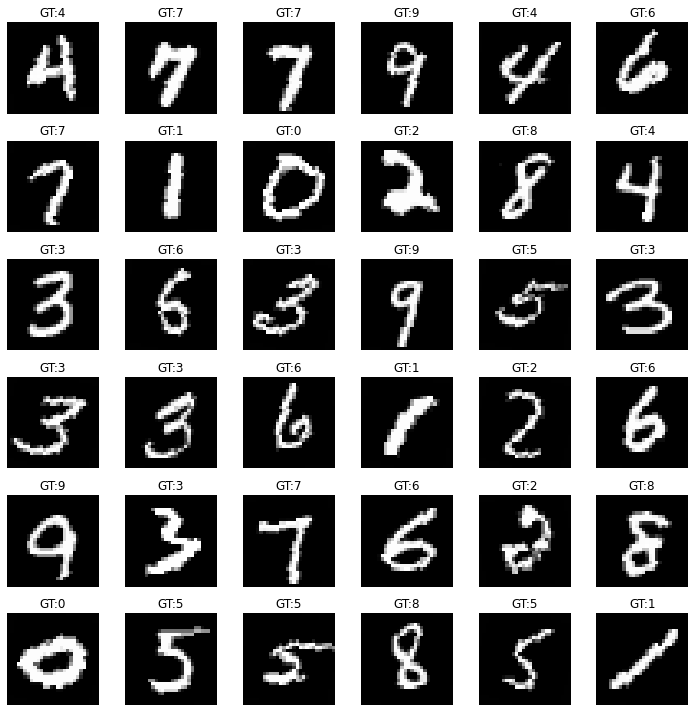

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
plot_data_grid(train_loader, mean= (0.1307,), std= (0.3081,), class_list=class_list, ncol=6,nrow=6)

# Importing Model


In [ ]:
from model import Net

## Plotting Model architecture

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


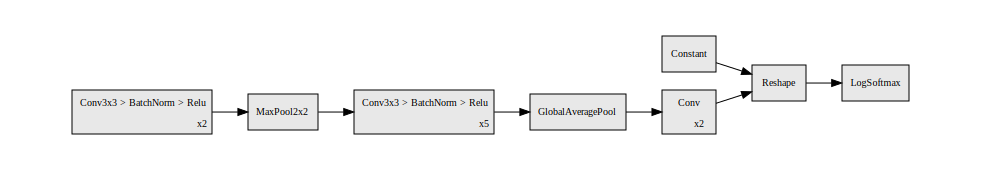

In [ ]:
model_plot = Net().to('cuda')
network_graph = hl.build_graph(model_plot, torch.zeros([1, 1, 28, 28]).to('cuda'))
network_graph.save("./images/network_1", "png")
network_graph

# Begin model training and validation process for Batch Normalization

In [ ]:
model_bn = Net().to(device)
summary(model_bn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             576
       BatchNorm2d-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 12, 12, 12]             864
       BatchNorm2d-7           [-1, 12, 12, 12]              24
            Conv2d-8           [-1, 12, 10, 10]           1,296
       BatchNorm2d-9           [-1, 12, 10, 10]              24
           Conv2d-10             [-1, 12, 8, 8]           1,296
      BatchNorm2d-11             [-1, 12, 8, 8]              24
           Conv2d-12             [-1, 12, 6, 6]           1,296
      BatchNorm2d-13             [-1, 12, 6, 6]              24
           Conv2d-14             [-1, 1

In [ ]:
from torch.optim.lr_scheduler import StepLR

model_bn = Net().to(device)
optimizer = optim.SGD(model_bn.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 6, gamma= 0.1)
trainer_bn = Train(model_bn, device, train_loader, optimizer, is_l1=True, lambda_l1=0.00005)
tester_bn = Test(model_bn, device, test_loader)

for epoch in range(1, 21):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer_bn()
    scheduler.step()
    test_loss, test_acc = tester_bn()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc), end=' | ')
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.10072483122348785 batch_id=937: 100%|██████████| 938/938 [00:25<00:00, 37.23it/s]


TRAIN set: Average loss: 0.3843, Train Accuracy: 89.49% | TEST set: Average loss: 0.0550, Test Accuracy: 98.33%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.1147, Train Accuracy: 97.59% | TEST set: Average loss: 0.0476, Test Accuracy: 98.55%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.1001, Train Accuracy: 98.08% | TEST set: Average loss: 0.0353, Test Accuracy: 98.95%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0932, Train Accuracy: 98.31% | TEST set: Average loss: 0.0315, Test Accuracy: 99.12%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0911, Train Accuracy: 98.36% | TEST set: Average loss: 0.0284, Test Accuracy: 99.21%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0879, Train Accuracy: 98.46% | TEST set: Average loss: 0.0284, Test Accur

In [ ]:
model_bn.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm5): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(12, 12, 

In [ ]:
print('Train Accuracy:', max(trainer_bn.accuracy))
print('Test Accuracy:', max(tester_bn.accuracy))

Train Accuracy: 99.19166666666666
Test Accuracy: 99.52


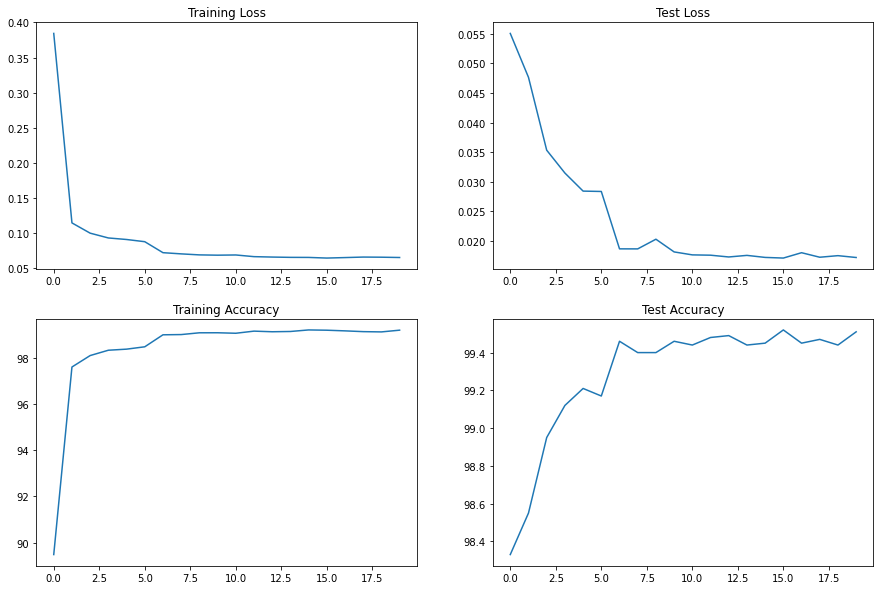

In [ ]:
plot_loss_acc(trainer_bn.loss, trainer_bn.accuracy, tester_bn.loss, tester_bn.accuracy)

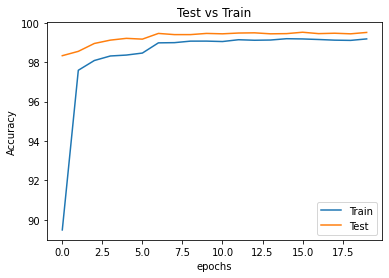

In [ ]:
plot_combined(trainer_bn.accuracy, tester_bn.accuracy,  x_label='epochs', y_label='Accuracy')

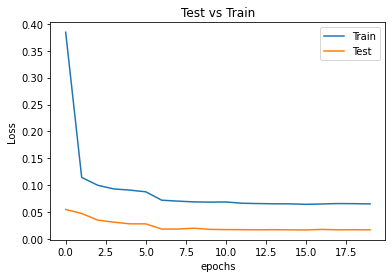

In [ ]:
plot_combined(trainer_bn.loss, tester_bn.loss,  x_label='epochs', y_label='Loss')

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results_bn = Results(model_bn, test_loader, device, mean, std, class_list)

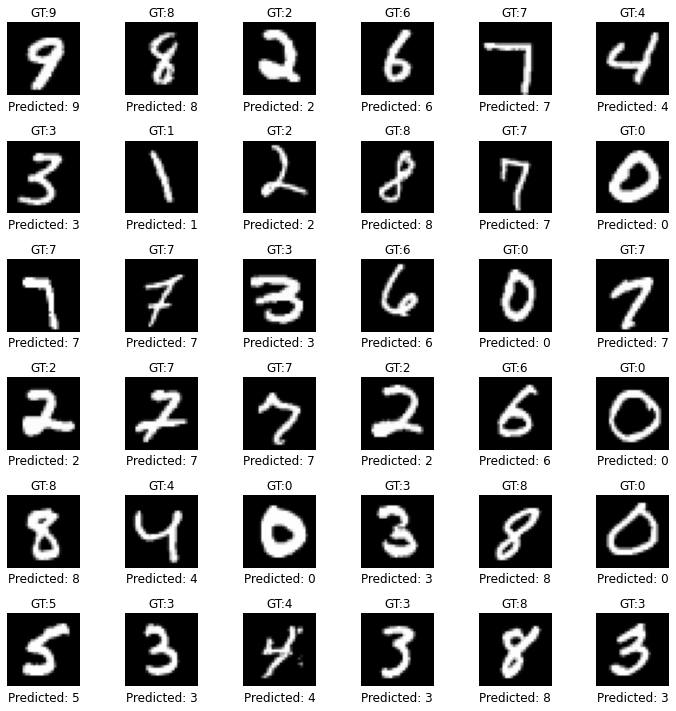

In [ ]:
results_bn.plot_batch()

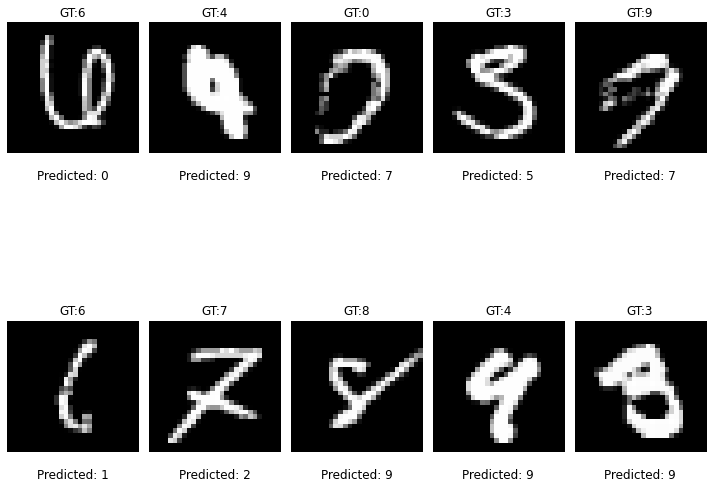

In [ ]:
results_bn.plot_incorrect(2, 5)

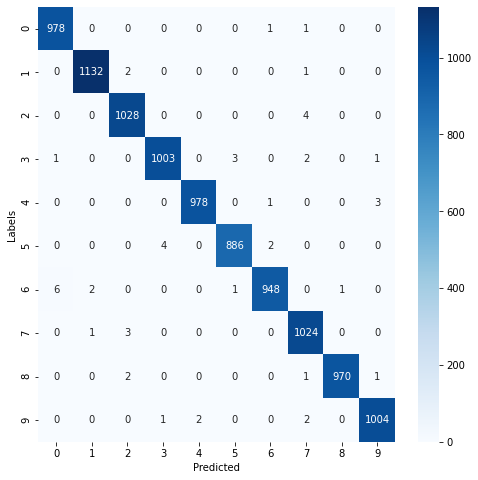

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 6 is 98.96
Accuracy of class 3 is 99.31
Accuracy of class 5 is 99.33
Accuracy of class 9 is 99.50
Accuracy of class 8 is 99.59
Accuracy of class 4 is 99.59
Accuracy of class 7 is 99.61
Accuracy of class 2 is 99.61
Accuracy of class 1 is 99.74
Accuracy of class 0 is 99.80


In [ ]:
results_bn.class_accuracy()

# Begin model training and validation process for Group Normalization

In [ ]:
model_gn = Net(normalization_type="GN").to(device)
summary(model_gn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
         GroupNorm-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             576
         GroupNorm-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 12, 12, 12]             864
         GroupNorm-7           [-1, 12, 12, 12]              24
            Conv2d-8           [-1, 12, 10, 10]           1,296
         GroupNorm-9           [-1, 12, 10, 10]              24
           Conv2d-10             [-1, 12, 8, 8]           1,296
        GroupNorm-11             [-1, 12, 8, 8]              24
           Conv2d-12             [-1, 12, 6, 6]           1,296
        GroupNorm-13             [-1, 12, 6, 6]              24
           Conv2d-14             [-1, 1

In [ ]:
from torch.optim.lr_scheduler import StepLR

model_gn = Net(normalization_type="GN").to(device)
optimizer = optim.SGD(model_gn.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 6, gamma= 0.1)
trainer_gn = Train(model_gn, device, train_loader, optimizer)
tester_gn = Test(model_gn, device, test_loader)

for epoch in range(1, 21):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer_gn()
    scheduler.step()
    test_loss, test_acc = tester_gn()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc), end=' | ')
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.1584932506084442 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.57it/s]


TRAIN set: Average loss: 0.5311, Train Accuracy: 84.13% | TEST set: Average loss: 0.0867, Test Accuracy: 97.54%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.1127, Train Accuracy: 96.77% | TEST set: Average loss: 0.0624, Test Accuracy: 98.25%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.0809, Train Accuracy: 97.70% | TEST set: Average loss: 0.0512, Test Accuracy: 98.46%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0679, Train Accuracy: 98.01% | TEST set: Average loss: 0.0367, Test Accuracy: 98.99%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0612, Train Accuracy: 98.17% | TEST set: Average loss: 0.0340, Test Accuracy: 99.03%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0540, Train Accuracy: 98.42% | TEST set: Average loss: 0.0323, Test Accur

In [ ]:
model_gn.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm1): GroupNorm(4, 8, eps=1e-05, affine=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm2): GroupNorm(4, 8, eps=1e-05, affine=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm3): GroupNorm(6, 12, eps=1e-05, affine=True)
  (conv4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm4): GroupNorm(6, 12, eps=1e-05, affine=True)
  (conv5): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm5): GroupNorm(6, 12, eps=1e-05, affine=True)
  (conv6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm6): GroupNorm(6, 12, eps=1e-05, affine=True)
  (conv7): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm7): GroupNorm(8,

In [ ]:
print('Train Accuracy:', max(trainer_gn.accuracy))
print('Test Accuracy:', max(tester_gn.accuracy))

Train Accuracy: 99.11666666666666
Test Accuracy: 99.42


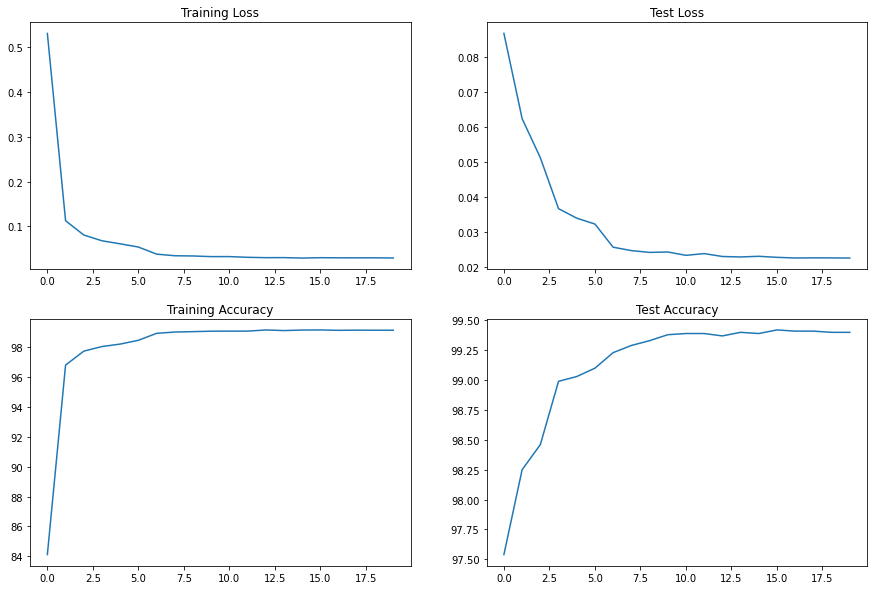

In [ ]:
plot_loss_acc(trainer_gn.loss, trainer_gn.accuracy, tester_gn.loss, tester_gn.accuracy)

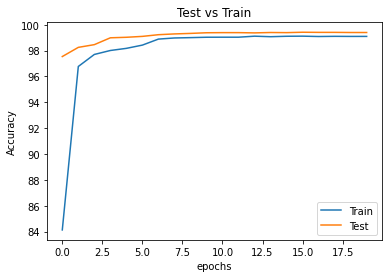

In [ ]:
plot_combined(trainer_gn.accuracy, tester_gn.accuracy,  x_label='epochs', y_label='Accuracy')

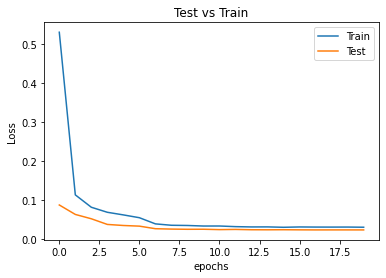

In [ ]:
plot_combined(trainer_gn.loss, tester_gn.loss,  x_label='epochs', y_label='Loss')

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results_gn = Results(model_gn, test_loader, device, mean, std, class_list)

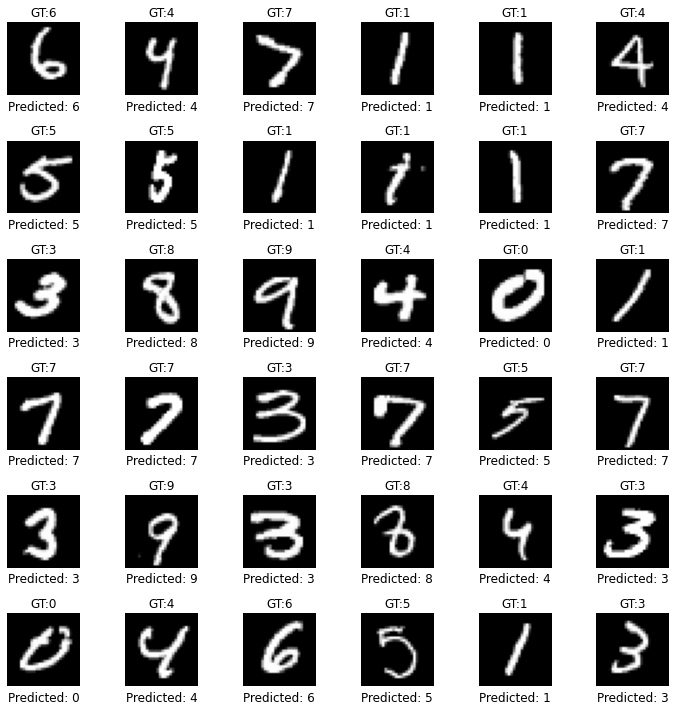

In [ ]:
results_gn.plot_batch()

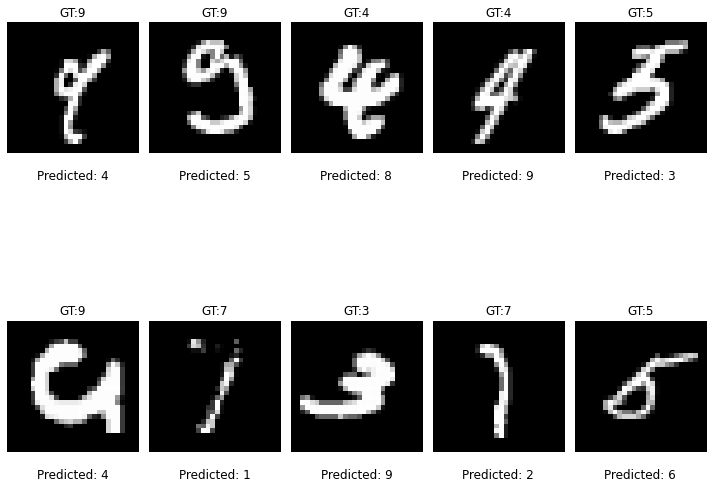

In [ ]:
results_gn.plot_incorrect(2, 5)

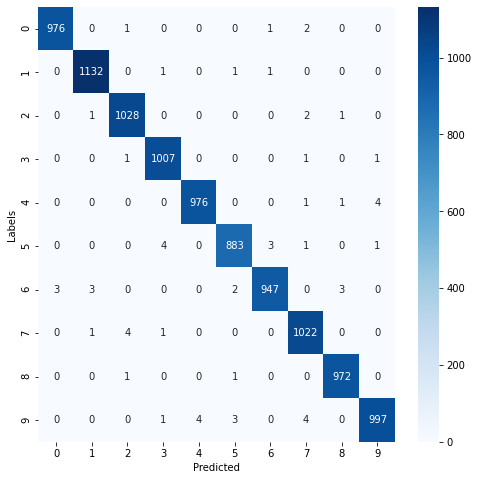

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 9 is 98.81
Accuracy of class 6 is 98.85
Accuracy of class 5 is 98.99
Accuracy of class 4 is 99.39
Accuracy of class 7 is 99.42
Accuracy of class 0 is 99.59
Accuracy of class 2 is 99.61
Accuracy of class 3 is 99.70
Accuracy of class 1 is 99.74
Accuracy of class 8 is 99.79


In [ ]:
results_gn.class_accuracy()

# Begin model training and validation process for Layer Normalization

In [ ]:
model_ln = Net(normalization_type="LN").to(device)
summary(model_ln, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
         GroupNorm-2            [-1, 8, 28, 28]              16
            Conv2d-3            [-1, 8, 28, 28]             576
         GroupNorm-4            [-1, 8, 28, 28]              16
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 12, 12, 12]             864
         GroupNorm-7           [-1, 12, 12, 12]              24
            Conv2d-8           [-1, 12, 10, 10]           1,296
         GroupNorm-9           [-1, 12, 10, 10]              24
           Conv2d-10             [-1, 12, 8, 8]           1,296
        GroupNorm-11             [-1, 12, 8, 8]              24
           Conv2d-12             [-1, 12, 6, 6]           1,296
        GroupNorm-13             [-1, 12, 6, 6]              24
           Conv2d-14             [-1, 1

In [ ]:
from torch.optim.lr_scheduler import StepLR

model_ln = Net(normalization_type="LN").to(device)
optimizer = optim.SGD(model_ln.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size= 6, gamma= 0.1)
trainer_ln = Train(model_ln, device, train_loader, optimizer)
tester_ln = Test(model_ln, device, test_loader)

for epoch in range(1, 21):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = trainer_ln()
    scheduler.step()
    test_loss, test_acc = tester_ln()
    
    print('TRAIN set: Average loss: {:.4f}, Train Accuracy: {:.2f}%'.format(train_loss,train_acc), end=' | ')
    print('TEST set: Average loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss,test_acc))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


loss=0.030944587662816048 batch_id=937: 100%|██████████| 938/938 [00:23<00:00, 39.46it/s]


TRAIN set: Average loss: 0.4866, Train Accuracy: 84.69% | TEST set: Average loss: 0.0936, Test Accuracy: 97.39%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 0.1083, Train Accuracy: 96.76% | TEST set: Average loss: 0.0514, Test Accuracy: 98.52%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 0.0797, Train Accuracy: 97.61% | TEST set: Average loss: 0.0482, Test Accuracy: 98.60%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 0.0717, Train Accuracy: 97.78% | TEST set: Average loss: 0.0414, Test Accuracy: 98.77%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 0.0628, Train Accuracy: 98.05% | TEST set: Average loss: 0.0499, Test Accuracy: 98.59%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 0.0558, Train Accuracy: 98.32% | TEST set: Average loss: 0.0450, Test Accur

In [ ]:
model_ln.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm1): GroupNorm(1, 8, eps=1e-05, affine=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm2): GroupNorm(1, 8, eps=1e-05, affine=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm3): GroupNorm(1, 12, eps=1e-05, affine=True)
  (conv4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm4): GroupNorm(1, 12, eps=1e-05, affine=True)
  (conv5): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm5): GroupNorm(1, 12, eps=1e-05, affine=True)
  (conv6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm6): GroupNorm(1, 12, eps=1e-05, affine=True)
  (conv7): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (norm7): GroupNorm(1,

In [ ]:
print('Train Accuracy:', max(trainer_ln.accuracy))
print('Test Accuracy:', max(tester_ln.accuracy))

Train Accuracy: 99.06333333333333
Test Accuracy: 99.35


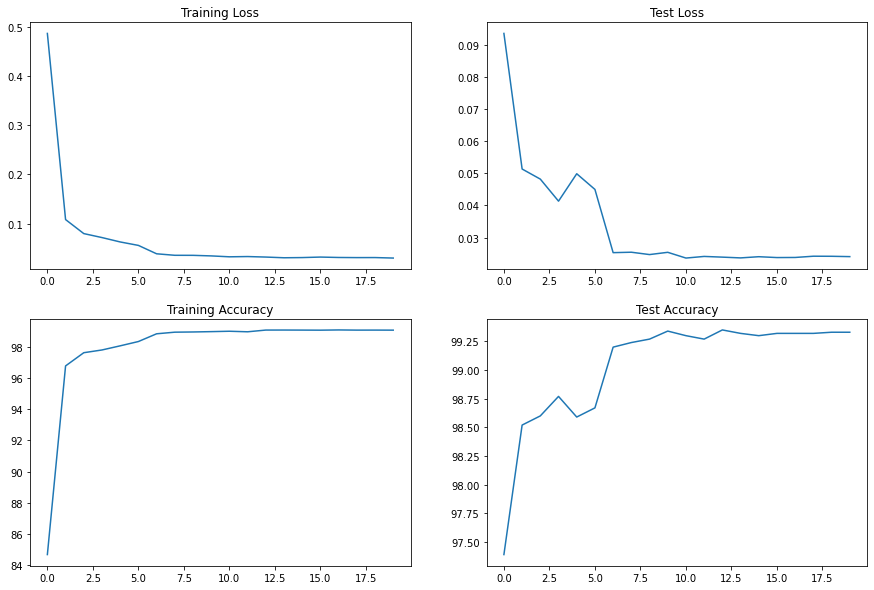

In [ ]:
plot_loss_acc(trainer_ln.loss, trainer_ln.accuracy, tester_ln.loss, tester_ln.accuracy)

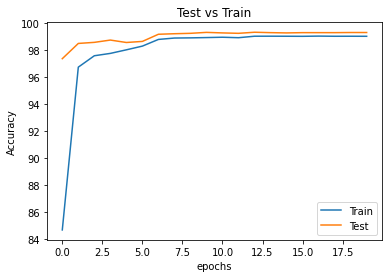

In [ ]:
plot_combined(trainer_ln.accuracy, tester_ln.accuracy,  x_label='epochs', y_label='Accuracy')

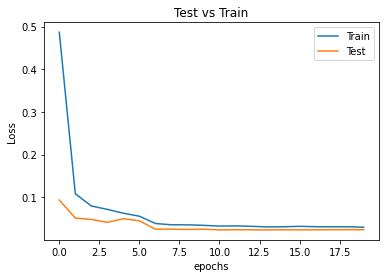

In [ ]:
plot_combined(trainer_ln.loss, tester_ln.loss,  x_label='epochs', y_label='Loss')

In [ ]:
class_list = [0,1,2,3,4,5,6,7,8,9]
mean= (0.1307,)
std= (0.3081,)
results_ln = Results(model_ln, test_loader, device, mean, std, class_list)

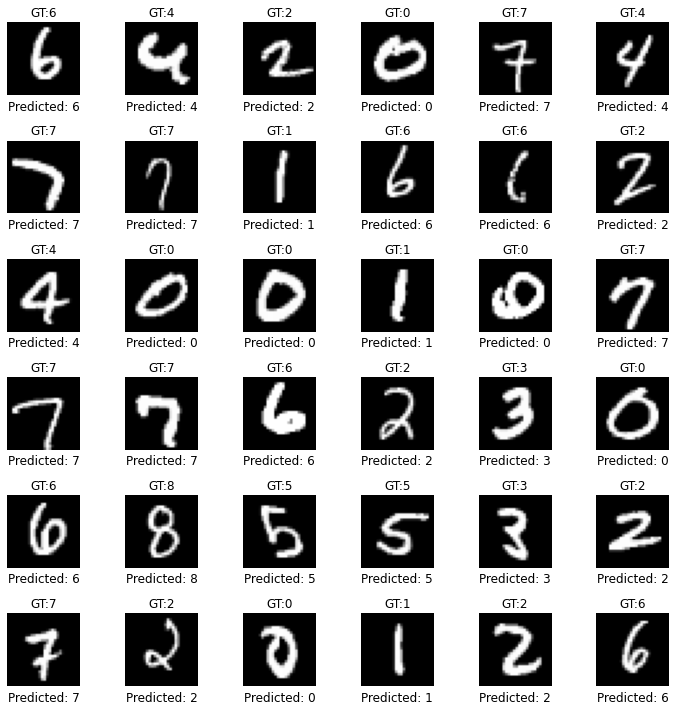

In [ ]:
results_ln.plot_batch()

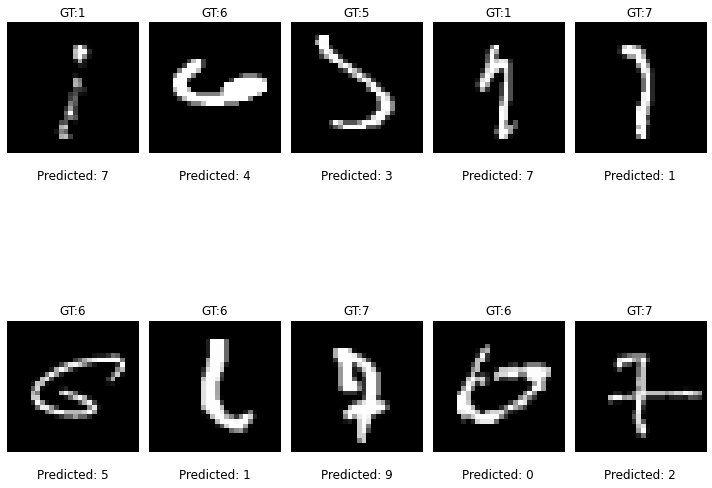

In [ ]:
results_ln.plot_incorrect(2, 5)

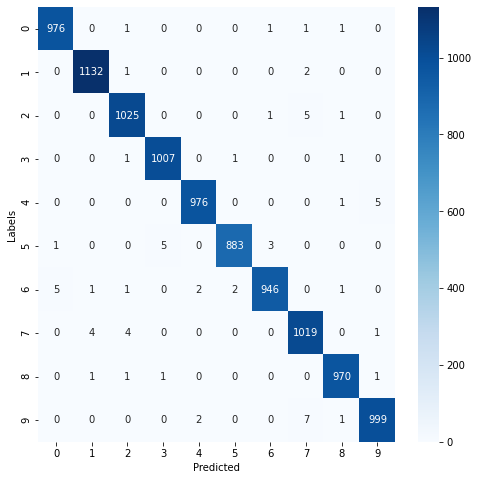

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class 6 is 98.75
Accuracy of class 5 is 98.99
Accuracy of class 9 is 99.01
Accuracy of class 7 is 99.12
Accuracy of class 2 is 99.32
Accuracy of class 4 is 99.39
Accuracy of class 8 is 99.59
Accuracy of class 0 is 99.59
Accuracy of class 3 is 99.70
Accuracy of class 1 is 99.74


In [ ]:
results_ln.class_accuracy()

# Plotting accuracies and losses together

In [ ]:
def plot_combined(list_of_plotters, *, x_label='epochs', y_label='Accuracy', title='Test vs Train', legend = ['Train', "Test"]):
    '''
    Plot multiple list of values, in a single plot.
    Parameters:
        list_of_plotters: A List of Accuracies/Loss which are arrays/lists.
        x_label: The X Axis Label (Optional Keywork Argument)
        y_label: The Y Axis Label (Optional Keywork Argument)
        title: The Title of the Graph (Optional Keywork Argument)
        legend: The Legend to be printed on Chart (Optional Keywork Argument) 
    '''
    plt.axes(xlabel= x_label, ylabel= y_label)
    for plotting_list in list_of_plotters:
        plt.plot(plotting_list)
    plt.title(title)
    plt.legend(legend)

In [ ]:
list_test_acc = [tester_bn.accuracy, tester_gn.accuracy, tester_ln.accuracy]
list_test_loss = [tester_bn.loss, tester_gn.loss, tester_ln.loss]

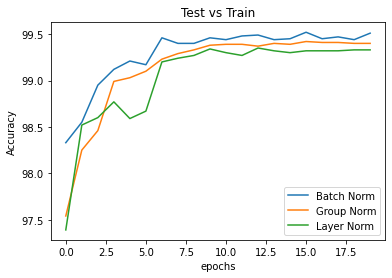

In [ ]:
plot_combined(list_test_acc, legend=["Batch Norm", "Group Norm", "Layer Norm"])

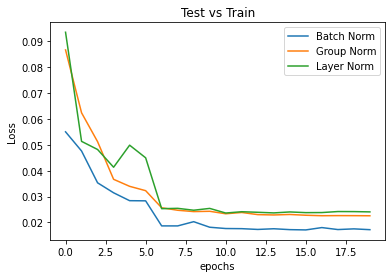

In [ ]:
plot_combined(list_test_loss, legend=["Batch Norm", "Group Norm", "Layer Norm"], y_label="Loss")